# Web Retrieval and Summarisation

In [21]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated, NotRequired
import operator
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

## Basic Internet Retrieval + Summarisation

In [25]:
search = DuckDuckGoSearchRun() 

model_id = "qwen2.5:0.5b"
llm = ChatOllama(model = model_id,
                num_predict = 256,
                temperature = 0.1)

class BasicState(TypedDict):
    search_query : str 
    search_results : NotRequired[str] 
    history : Annotated[list[str], operator.add]
    summary_content : NotRequired[str]

In [29]:
def retrieval_node(state : BasicState):
    raw_results = search.run(state["search_query"])
    return {
        "search_results" : raw_results,
        "history" : [f"Retrieved : {raw_results[:50]}"]  
    }

def summarizer_node(state : BasicState):
    prompt = f'''
    Summarize the following search results from the internet into clear and concise points.
    Return the points in numbered list format starting from 1.
    #Search Results 

    {state["search_results"]}
    ''' 

    summary = llm.invoke(prompt)
    return {
        'summary_content' : summary.content,
        'history' : ["Summarised search results"]
    }

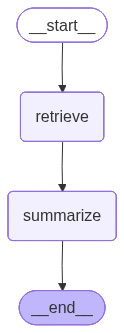

In [ ]:
builder = StateGraph(BasicState)

builder.add_node("retrieve", retrieval_node)
builder.add_node("summarize", summarizer_node)

builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "summarize")
builder.add_edge("summarize", END)

graph = builder.compile()

In [31]:
query = "LEGO Batman 2026 sets"
input = {
    'search_query' : query,
    'history' : []
}

result = graph.invoke(input)

print(result["summary_content"])


1. The 20th Anniversary LEGO Batman sets are now available for purchase.
2. The sets include exclusive digital content for the recently announced LEGO Batman: Legacy of the Dark Knight videogame, which is set to launch in 2026.
3. The sets will be identical to the 2006 sets, featuring a Joker helicopter and a Batwing, as well as a Batman vehicle and Catcycle.
4. A new reveal has been made for the LEGO Batman Legacy of the Dark Knight sets, which are rumored to be the same basic concepts as the 2006 sets: a Joker helicopter + a Batwing, a Batman vehicle + Catcycle ect.
5. The LEGO DC 2026 Batman sets are also available for purchase and will release on March 1, 2026.
6. The sets draw from different eras of the Batman movie franchise and connect to the LEGO Batman brand.
7. The new sets will be released in a series that ties into the 20 years of LEGO Batman, with each set drawing on different eras of the Batman movie franchise.


# Multi Agent 

In [ ]:
search = DuckDuckGoSearchRun() 

model_id = "qwen2.5:0.5b"
llm = ChatOllama(model = model_id,
                num_predict = 256,
                temperature = 0.1)

class BasicState(TypedDict):
    search_query : str 
    search_results : NotRequired[str] 
    history : Annotated[list[str], operator.add]
    summary_content : NotRequired[str]

In [32]:
# One agent for query optimisation and other for summarisation

optimisation_llm = ChatOllama(model = "qwen2.5:0.5b", temperatute = 0.1)
summarizer_llm = ChatOllama(model = "llama3.2:1b", temperature = 0.1)

In [37]:
def research_node(state : BasicState):
    prompt = f'''
    You are a search engine agent. You have to optimise the given query such that it will retrieve rich information when used to browse the internet using a search engine.

    #Search Query

    {state['search_query']}
    '''

    optimized_query = optimisation_llm.invoke(prompt).content
    raw_results = search.run(optimized_query)

    return {
        'search_results' : raw_results, 
        'history' : ['Search done using Brave Browser']
    }

def summarizer_node(state : BasicState):
    prompt = f'''
    Summarize the following search results from the internet into clear and concise points.
    Return the points in numbered list format starting from 1.
    #Search Results 

    {state["search_results"]}
    ''' 

    summary = summarizer_llm.invoke(prompt)
    return {
        'summary_content' : summary.content,
        'history' : ["Summarised search results"]
    }

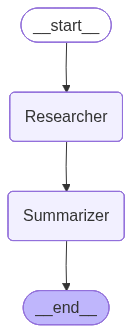

In [38]:
builder = StateGraph(BasicState)

builder.add_node("Researcher", research_node)
builder.add_node("Summarizer", summarizer_node)

#builder.add_edge(START, research_node)
builder.set_entry_point("Researcher")
builder.add_edge("Researcher", "Summarizer")
builder.add_edge("Summarizer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
query = "LEGO Batman 2026 sets"
input = {
    'search_query' : query,
    'history' : []
}

result = graph.invoke(input)

print(result["summary_content"])

Here are the summarized points in numbered list format starting from 1:

1. Lego Batman is a community celebrating the Lego Batman/DC Super Heroes franchise, including sets, video games, movies, minifigures, collectibles, and more.
2. The search results mention that there are various versions of the 1939 film "Ben-Hur," with some being considered definitive (e.g., the original version) while others are rare or hard to find (e.g., the 1925 silent version).
3. There is a connection between Lego Batman and the College of Education at Georgia Southern University, which offers expertise in various fields.
4. The search results also mention that there is a project called "lightsails" being developed for tiny, superfast spacecraft with chip-based technology, but its momentum has waned.

Note: These points are based on the provided text and may not be comprehensive or up-to-date.
